<a href="https://colab.research.google.com/github/Jhonyd55/MASTER-IA/blob/main/Colab_Notebooks/PROYECTO_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ANÁLISIS DE CNN PRE-ENTRENADAS CON TRANSFER LEARNING PARA EL ANÁLISIS DE LESIONES PIGMENTADAS**

En este TFM se realiza el análisis de una serie de CNN generadas a partir de CNN pre-entrenadas, tendremos en cuenta las CNN que han ganado los últimos desafíos **ISIC CHALLANGER**.

Utilizaremos la librería **Keras** y sus múltiples herramientas para el análisis de las CNN




In [ ]:
#https://www.kaggle.com/code/zhyaqi/skin-lesion-inceptionv3
!pip install visualkeras
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
import visualkeras #para visualizar modelo de cnn
from keras import layers 
from PIL import ImageFont
import gc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**DEFINIREMOS LA CONFIGURACIÓN PREVIA**

 Indicaremos las CNN pre-entrenadas con las que trabajaremos 
* Xception
* VGG16 
* InceptionV3
* ResNet50
* DenseNet201
* MobileNetV2

In [ ]:


# Lista de modelos utilizados para el análisis.
#listModel=['Xception' , 'VGG16' , 'InceptionV3' , 'ResNet50','DenseNet201','MobileNetV2']

listModel=['VGG16' ]

# Cantidad de categorias que define el DataSet
num_classes = 7
#Tamaño del lote para entrenamiento 
batch_size = 256    
# Number of epochs to train for
epochs = 40
# factor de dropout
drpout= 0.3
#Solo se configuraran las capas de salida
feature_extract = True


In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
#print("PyTorch Version: ",torch.__version__)
#print("Torchvision Version: ",torchvision.__version__)

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
from keras.applications import Xception , VGG16 , VGG19 , ResNet50 , ResNet50V2 , ResNet101 , ResNet101V2 , ResNet152 , ResNet152V2 , InceptionV3 , InceptionResNetV2 , MobileNet , MobileNetV2 , DenseNet121 , DenseNet169 , DenseNet201 , NASNetMobile , NASNetLarge
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

def initialize_model(model_name, num_classes, feature_extract,folder,drpout, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_shape = (100, 100, 3)
    num_labels = num_classes
    base_model=[]
 # ['Xception ' , 'VGG16 ' , 'VGG19 ' , 'ResNet50 ' , 'ResNet50V2 ' , 'ResNet101 ' , 'ResNet101V2 ' , 'ResNet152 ' , 'ResNet152V2 ' , 'InceptionV3 ' , 'InceptionResNetV2 ' , 'MobileNet ' , 'MobileNetV2 ' , 'DenseNet121 ' , 'DenseNet169 ' , 'DenseNet201 ' , 'NASNetMobile ' , 'NASNetLarge ' , 'EfficientNetB0 ' , 'EfficientNetB1 ' , 'EfficientNetB2 ' , 'EfficientNetB3 ' , 'EfficientNetB4 ' , 'EfficientNetB5 ' , 'EfficientNetB6 ' , 'EfficientNetB7 ' , 'EfficientNetV2B0 ' , 'EfficientNetV2B1 ' , 'EfficientNetV2B2 ' , 'EfficientNetV2B3 ' , 'EfficientNetV2S ' , 'EfficientNetV2M ' , 'EfficientNetV2L ' , 'ConvNeXtTiny ' , 'ConvNeXtSmall ' , 'ConvNeXtBase ' , 'ConvNeXtLarge ' , 'ConvNeXtXLarge ']

    if model_name == "Xception":
        """ Xception
        """
        base_model = Xception(include_top=False, input_shape=input_shape,pooling = 'avg',weights="imagenet")

    elif model_name == "VGG16":
        """ VGG16
        """
        base_model = VGG16(include_top=False, input_shape=input_shape,pooling = 'avg',weights="imagenet")

    elif model_name == "ResNet50":
        """ ResNet50
        """
        base_model = ResNet50(include_top=False, input_shape=input_shape,pooling = 'avg',weights="imagenet")
    elif model_name == "InceptionV3":
        """ InceptionV3
        """
        base_model = InceptionV3(include_top=False, input_shape=input_shape,pooling = 'avg',weights="imagenet")
    elif model_name == "MobileNetV2":
        """ MobileNetV2
        """
        base_model = MobileNetV2(include_top=False, input_shape=input_shape,pooling = 'avg',weights="imagenet")
    elif model_name == "DenseNet201":
        """ DenseNet201
        """
        base_model = DenseNet201(include_top=False, input_shape=input_shape,pooling = 'avg',weights="imagenet")    
    else:
        #print("CNN no valida ...")
        exit()
    # El modelo de CNN resultante consta de las Capas Iniciales de la CNN pre-entrenada seleccionada y
    # los correspondientes pesos 
    model = Sequential()
    model.add(base_model)
    model.add(Dropout(drpout))
    # Capa oculta adicional para mejorar y asegurar el aprendizaje de la red junto con Droput para evitar el sobre ajuste.
    model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
    model.add(Dropout(drpout))
    
    model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

    for layer in base_model.layers:
        layer.trainable = True
    
    
    if os.path.exists(folder):
        rmtree(folder)
    os.mkdir(os.path.join( folder))
    #font  = ImageFont.truetype("arial.ttf", 15)
    visualkeras.layered_view(model,to_file=folder+model_name+'.png',legend=True).show() 
    return model

# Initialize the model for this run
#model = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
##print(model)

In [ ]:

import numpy as np          # linear algebra
import pandas as pd         # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2
from cv2 import imread, resize # manipulating the images
from keras.optimizers import Adam
import os

In [ ]:
import os

if not(os.path.exists('skin-cancer-mnist-ham10000.zip')): 
  !pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## conectamos la cuenta de google colab con drive

if not(os.path.exists('skin-cancer-mnist-ham10000.zip')):
  from google.colab import drive
  drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if not(os.path.exists('skin-cancer-mnist-ham10000.zip')):
  !chmod 600 drive/'My Drive'/Colab_Notebooks/kaggle.json
  !mkdir /root/.kaggle/
  !cp drive/'My Drive'/Colab_Notebooks/kaggle.json /root/.kaggle/


mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [ ]:
import os
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shutil import rmtree
folder = 'input'
if os.path.exists(folder):
    rmtree(folder)
os.mkdir(os.path.join( folder))
folder = '/input/skin-cancer-mnist-ham10000/'
if os.path.exists(folder):
    rmtree(folder)
os.mkdir(os.path.join( 'input','skin-cancer-mnist-ham10000'))
f = './drive/MyDrive/Colab_Notebooks/CNN/'
if not os.path.exists(f):
  os.mkdir(os.path.join( f))


In [ ]:
if not(os.path.exists('skin-cancer-mnist-ham10000.zip')):
  !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
  !unzip skin-cancer-mnist-ham10000.zip -d ./input/skin-cancer-mnist-ham10000/
  !cp drive/MyDrive/Colab_Notebooks/kaggle.json /root/.kaggle/
else:
  !unzip skin-cancer-mnist-ham10000.zip -d ./input/skin-cancer-mnist-ham10000/

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ./input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ./input/skin-cancer-mnist-

In [ ]:
df_skin = pd.read_csv('./input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df_skin.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
lesion_type_dict = {
    'nv': 'nevus melanocítico',
    'mel': 'Melanoma',
    'bkl': 'Queratosis benigna ',
    'bcc': 'carcinoma basocelular',
    'akiec': 'Queratosis actínica / enfermedad de Bowen',
    'vasc': 'lesión vascular',
    'df': 'dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}
lesion_names = ['nevus melanocítico',
    'Melanoma',
    'Queratosis benigna ',
    'carcinoma basocelular',
    'Queratosis actínica / enfermedad de Bowen',
    'lesión vascular',
    'dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']
df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)
df_skin['lesion_type'].value_counts()

nevus melanocítico                           6705
Melanoma                                     1113
Queratosis benigna                           1099
carcinoma basocelular                         514
Queratosis actínica / enfermedad de Bowen     327
lesión vascular                               142
dermatofibroma                                115
Name: lesion_type, dtype: int64

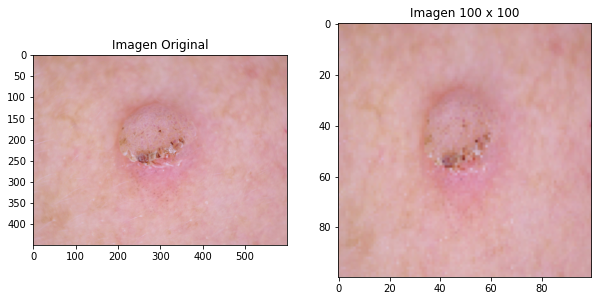

In [ ]:
# Reading a random image from our data set
fname_images = np.array(df_skin['image_id'])
file_to_read ='./input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/'+str(fname_images[6])+'.jpg'

# Resizing the read image to 100x100
img = imread(file_to_read)
img2 = resize(img, (100, 100))

# Show one exampe image before and after
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Imagen Original')
plt.subplot(1, 2, 2)
plt.imshow(img2[:, :, ::-1])
plt.title('Imagen 100 x 100' )
plt.savefig("./drive/MyDrive/Colab_Notebooks/CNN/Imagen redimensionada.png",dpi=300)
#plt.show()

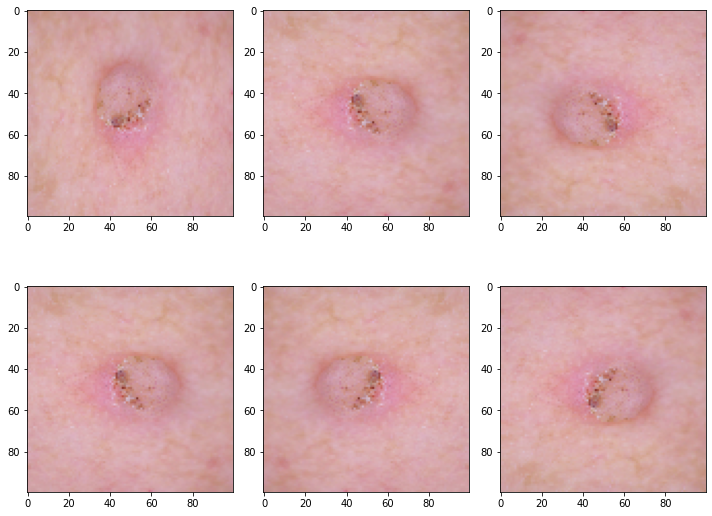

In [ ]:
def produce_new_img(img2: cv2) -> tuple:
    """
    
    Esta funcion agrega 5 imagenes adicionales, al realizar rotaciones a la imagen original
    El objetivo es reducir el sobreajuste en una sola clase.
    """
    img1 = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    img2 = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img3 = cv2.rotate(img2, cv2.ROTATE_180)
    img4 = cv2.flip(img2, 0)
    img5 = cv2.flip(img2, 1)
    new_imge5 = img1, img2, img3, img4 ,img5
    return new_imge5

def show_example() -> None:
    """
    para mostras las imagenes como han sido manipuladas
    """
    plt.figure(figsize = (10, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(img2[:, :, ::-1])
    for i in range(5):
        plt.subplot(2, 3, 2+i)
        plt.imshow(new_img[i][:, :, ::-1])
    plt.tight_layout()
    plt.savefig("./drive/MyDrive/Colab_Notebooks/CNN/Imagen rotada.png",dpi=300)
    #plt.show()

# Invoking our function :)
new_img = produce_new_img(img2)
# Display an example by invoking show_example func
show_example()

In [ ]:
x = []          # Mantenga las imágenes redimensionadas.
y = []          # Mantenga la identificación de la lesión de la imagen del conjunto de datos.

# Listing all files in the part_1, part_2 dirs
lista1 = os.listdir('./input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/')
lista2 = os.listdir('./input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/')

# [+] Manejo de imágenes del directorio de la parte 1
for i in range(len(lista1)):
    # [+] Características: leer y cambiar el tamaño de la foto.
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='./input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/' + str(fname_image)  # resolve image name
    img = imread(file_to_read)                                  # read the image 
    img2 = resize(img,(100, 100))                               # resise our image
    x.append(img2)                                              # append the new image to the list x.
    
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6, rotating them 
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])

    # inform the user with the number of loaded images each 100 img.
    #if i % 100 == 0:
        #print(i, 'images loaded')


# [+] Handling images from part 2 directory
for i in range(len(lista2)):

    # [+] Features: reading and resize the photo.
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='./input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/' + str(fname_image)


    img = imread(file_to_read)
    img2 = resize(img,(100, 100))
    x.append(img2)
    
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # [+] Add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    
    #if i % 100 == 0: # [+] Inform the user with the number of loaded images each 100 img.
        #print(len(lista1) + i,'images loaded')

In [ ]:
x = np.array(x)
y = np.array(y)

# convert y (targets) array as required by softmax activation function
y_train = to_categorical(y, num_classes = 7)

In [ ]:
from numpy import save
def numpyArray2text(Array,folder,name):
  np.save(folder+name+'.npy', Array)

def text2Array(folder,name):
  content = np.load(folder+name+'.npy',encoding='ASCII')
  return content

In [ ]:
from numpy import load
f0lder ='/content/drive/MyDrive/Colab_Notebooks/'
# dividido dataset 70% para entrenamiento y 30% para datos de prueba
if not((os.path.exists(f0lder,'X_train.npy') and os.path.exists(f0lder,'X_test.npy'))and(os.path.exists(f0lder,'y_train.npy') and os.path.exists(f0lder,'y_test.npy'))): 
  X_train, X_test, y_train, y_test = train_test_split(x,y_train,test_size = 0.30, random_state = 50,stratify = y)       
# [+] distribución del dataset.
  print('lote de entrenamiento =', X_train.shape)
  print('lote de prueba =', X_test.shape)
else:
  X_train=text2Array(f0lder,'X_train')
  X_test=text2Array(f0lder,'X_test')
  y_train=text2Array(f0lder,'y_train')
  y_test=text2Array(f0lder,'y_test')

In [ ]:
def est_class_weights(dis_id: np.array) -> dict:
    """ dado el conjunto de datos estimamos si esta desequilibro el dataset, en especial si hay imagenes que no correspondan al estudio,
    """
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))

y_id = np.array(df_skin['lesion_ID'])
new_class_weights = est_class_weights(y_id)
#print('El problema está desequilibrado. Necesitamos proporcionar class-weights')
#print(new_class_weights)

In [ ]:
def figure_accuracy(folder,model_name,history) :
    plt.figure(figsize=(8, 8))
    plt.title(model_name+" ACCUARY", fontsize=20)
    plt.plot(history.history['accuracy'],linewidth=3)
    plt.plot(history.history['val_accuracy'],linewidth=3)
    plt.title('Model Accuracy '+model_name,fontsize=20)
    plt.ylabel('Accuracy',fontsize=16)
    plt.xlabel('Epoch',fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend(['accuracy', 'val_accuracy'], loc='lower right',fontsize=16)
    nameFigure=folder+model_name+'accuary.png'
    plt.savefig(nameFigure,dpi=300)
    #plt.show()

def figure_loss(folder,model_name,history) :
    plt.figure(figsize=(8, 8))
    plt.title(model_name+" LOSS", fontsize=20)
    plt.plot(history.history['loss'],linewidth=3)
    plt.plot(history.history['val_loss'],linewidth=3)
    plt.title('Model Loss',fontsize=20)
    plt.ylabel('Loss',fontsize=16)
    plt.xlabel('Epoch',fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend(['Train', 'Test'], loc='upper right',fontsize=16)
    nameFigure=folder+model_name+'loss.png'
    plt.savefig(nameFigure,dpi=300)
    plt.show()


In [ ]:


def test_model(y_pred,y_test):
    """ Tunning the accurate results and inaccurate results

    Returns:
        (total, accurate) [tuple]: tuple of total tested test-cases, accurate
    """
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    for i in range(len(y_pred)):
        if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1
    return (total, accurate)



In [ ]:
import numpy as np


def plot_confusion_matrix(cm,model_name,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8,4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    nameFigure=model_name+'matrix de confusion '+'.png'
    plt.savefig(nameFigure,dpi=300)
    #plt.show()



In [ ]:
def analizer1(folder,model_name,X_test,y_test):
  message='\n\t\t'+model_name+'\n\n\n'
  best_model = load_model(folder+model_name+'.h5')
  # Compute predictions
  y_pred_prob = np.around(best_model.predict(X_test),3)
  y_pred = np.argmax(y_pred_prob,axis=1)

  y_test2 = np.argmax(y_test,axis=1)
  # [+] inform the user with model Accuracy %
  scores = best_model.evaluate(X_test, y_test, verbose = 1)
  ##print("Accuracy: %.2f%%" % (scores[1] * 100))
  Accuracy="{:.2f}".format(scores[1] * 100)
  #Accuracy for each type
  acc_tot= []

  for i in range(7):
      acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
      lab_parz = lesion_names[i]
      message= message+'accuracy for '+str(lab_parz) + ' = '+str(acc_parz) +' ''\n'
      acc_tot.append(acc_parz)
      
  plt.figure(figsize=(16,16))
  for i in range(16):
      plt.subplot(4,4,i+1)
      index = i+100
      plt.imshow(X_test[index,:,:,::-1],fontsize=30)
      label_exp = lesion_names[y_test2[index]]  #expected label
      label_pred = lesion_names[y_pred[index]]  #predicted label
      label_pred_prob = round(np.max(y_pred_prob[index])*100)
      plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)',fontsize=60)
  plt.ylabel('')
  plt.tight_layout()
  plt.savefig(folder+'final_figure.png',dpi=300)
  #plt.show()
  return message

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
def Analizer2(y_test, y_prediction):
  acc=accuracy_score(y_test, y_prediction)
  recall=recall_score(y_test, y_prediction, average=None)
  precision=precision_score(y_test, y_prediction, average=None)
  f1=f1_score(y_test, y_prediction, average=None)
  return acc,recall,precision,f1

In [ ]:
def result2txt(folder,message):
  f = open (folder+"resultados.txt",'w')
  f.write(message)
  f.close()

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score



# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(target,y_test, y_pred,folder, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
  
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)),linewidth=2)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing',linewidth=2)
    c_ax.legend(fontsize=8)
    c_ax.set_xlabel('False Positive Rate',fontsize=20)
    c_ax.set_ylabel('True Positive Rate',fontsize=20)
    #c_ax.set_yticks()
    #c_ax.set_xticks()
    plt.savefig(folder+model_name+' ROC AUC score.png',dpi=300)
    #plt.show()
    return roc_auc_score(y_test, y_pred, average=average)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm,model_name,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    nameFigure=model_name+'matrix de confusion '+'.png'
    plt.savefig(nameFigure,dpi=300)
    #plt.show()



In [ ]:

##########################
### [+] Training phase ###
##########################

def mod_checkpoint_callback(folder,model_name):
    """
    Saving our model
    
    Returns:
        None: Saving a checkpoint of the model.
    """
    trained_model = ModelCheckpoint(filepath = folder+model_name+'.h5',  # result file name
                             save_weights_only = False,     # Save all training results/params.
                             monitor = 'val_accuracy',      # check our model accuracy if it's step forward.
                             mode = 'auto',                 # enable auto save.
                             save_best_only = True,         # if ac_new > ac_old
                             verbose = 1)
    return trained_model

def trainCNN(model_name, num_classes, epochs, feature_extract,batch_size,X_train,y_train,X_test,y_test,drpout):
  message=''
  folder='./drive/MyDrive/Colab_Notebooks/CNN/'+model_name+'/'
  if not os.path.exists(folder):
    
    os.mkdir(os.path.join( folder))
  
  model = initialize_model(model_name, num_classes, feature_extract, folder,drpout,use_pretrained=True)


  # Seguimiento de procesos por epochs
  early_stopping_monitor = EarlyStopping(patience = 100, monitor = 'val_accuracy')

  model_checkpoint_callback = mod_checkpoint_callback(folder,model_name)

  # Estimate the model data if it was big one.
  optimizer = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

  datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
  datagen.fit(X_train)


  history = model.fit(datagen.flow(X_train,y_train),
                      epochs = epochs,
                      batch_size = batch_size,
                      shuffle = True,
                      callbacks = [early_stopping_monitor, model_checkpoint_callback],
                      validation_data = (X_test, y_test),
                      class_weight = new_class_weights
                  )


  y_pred = model.predict(X_test)
  total, accurate = test_model(y_pred,y_test)
  message= message+'Total-test-data;'+str( total)+ '\taccurately-predicted-data: '+str(accurate)+ '\t wrongly-predicted-data: '+str( total - accurate)+'\n'
  message= message+'Accuracy:'+ str(round(accurate / total * 100, 3)) +'%'+'\n'+'\n'+'\n'
  

  #Predict
  y_pred = model.predict(X_test)
  y_prediction = np.argmax (y_pred, axis = 1)
  y_test2=np.argmax(y_test, axis=1)
  #Create confusion matrix and normalizes it over predicted (columns)
  from sklearn.metrics import confusion_matrix
  matrix = confusion_matrix(y_test2, y_prediction , normalize='pred')
  plot_confusion_matrix(matrix,
                      folder+model_name+" ",
                        lesion_names,
                        title='Confusion matrix',
                        cmap=None,
                        normalize=True)

  acc,recall,precision,f1=Analizer2(y_test2, y_prediction)
  dframe = pd.DataFrame(zip([ '%.2f' % elem for elem in recall] ,[ '%.2f' % elem for elem in precision],[ '%.2f' % elem for elem in f1]),index= lesion_names, columns = ['recall','precision','f1'])
  #print(dframe)
  message=message+dframe.to_string()+'\n\n'
  #print(message)
  result2txt(folder,message) 
  return lesion_names,y_test2,y_prediction,folder,history



58889256/58889256 [==============================] - 4s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
582/582 [==============================] - ETA: 0s - loss: 4.7552 - accuracy: 0.4496
Epoch 1: val_accuracy improved from -inf to 0.62447, saving model to ./drive/MyDrive/Colab_Notebooks/CNN/VGG16/VGG16.h5
582/582 [==============================] - 94s 143ms/step - loss: 4.7552 - accuracy: 0.4496 - val_loss: 3.3053 - val_accuracy: 0.6245
Epoch 2/40
582/582 [==============================] - ETA: 0s - loss: 2.6196 - accuracy: 0.6448
Epoch 2: val_accuracy improved from 0.62447 to 0.66424, saving model to ./drive/MyDrive/Colab_Notebooks/CNN/VGG16/VGG16.h5
582/582 [==============================] - 80s 138ms/step - loss: 2.6196 - accuracy: 0.6448 - val_loss: 2.0657 - val_accuracy: 0.6642
Epoch 3/40
582/582 [==============================] - ETA: 0s - loss: 1.7123 - accuracy: 0.7002
Epoch 3: val_accuracy improved from 0.66424 to 0.70765, saving model to ./drive/MyDrive/Colab_Notebooks/CNN/VGG16/VGG16.h5
582/582 [==============================] - 82s 141ms/step - loss: 1.7123 - acc

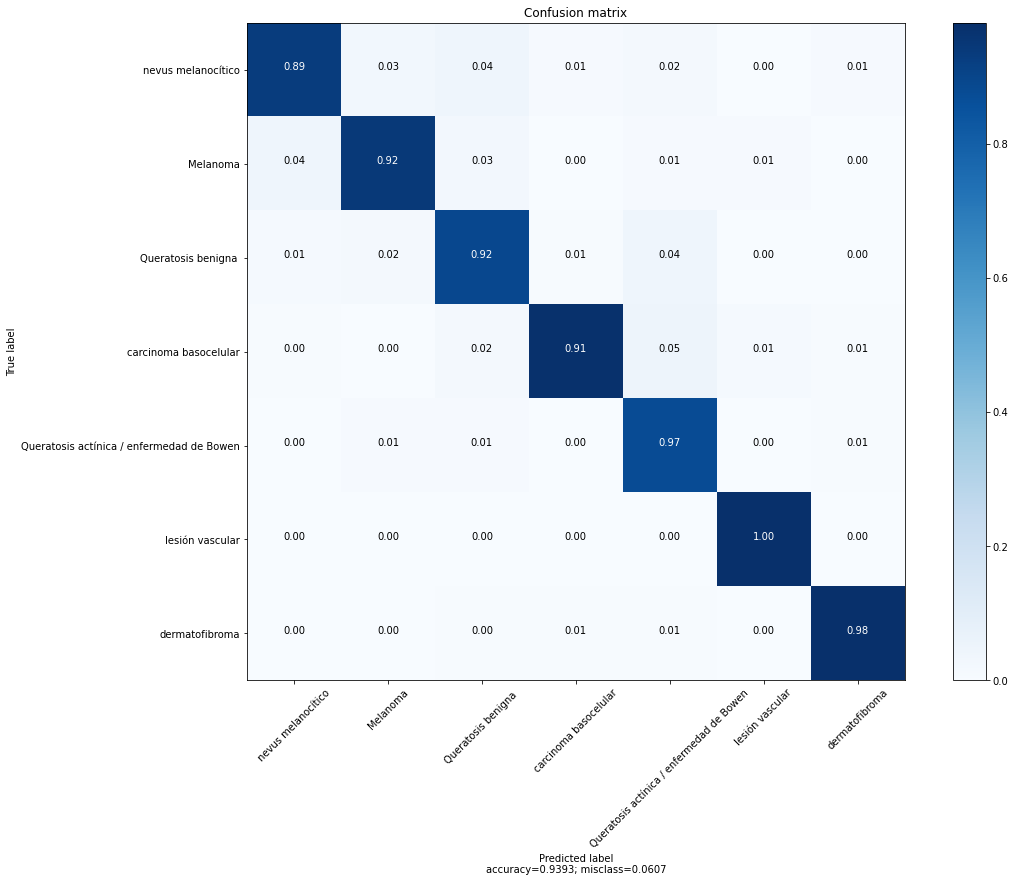

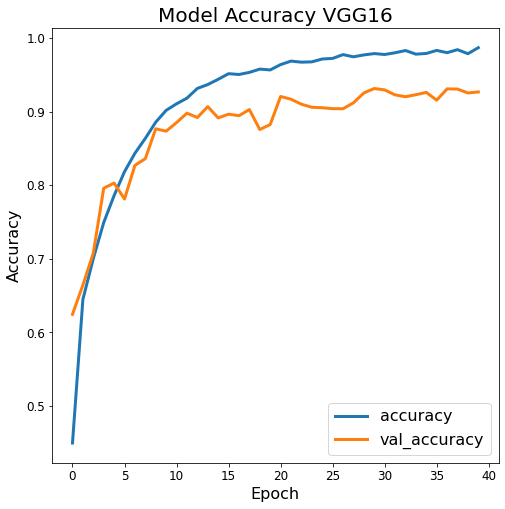

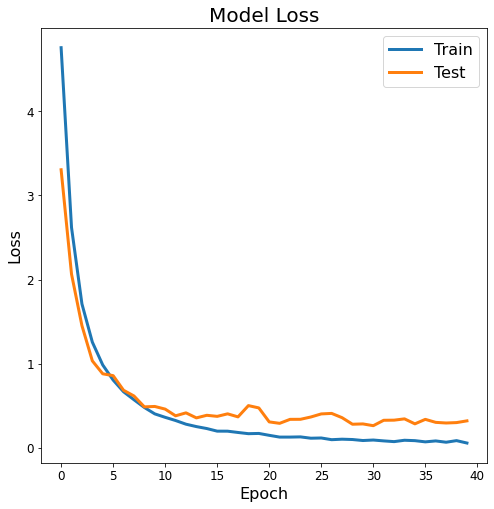

In [ ]:
for model_name in listModel:
  l_names,y_test2,y_prediction,f,history=trainCNN(model_name, num_classes, epochs, feature_extract,batch_size,X_train,y_train,X_test,y_test,drpout)
  figure_accuracy(f,model_name,history)
  figure_loss(f,model_name,history)
  multiclass_roc_auc_score(l_names,y_test2,y_prediction,f)


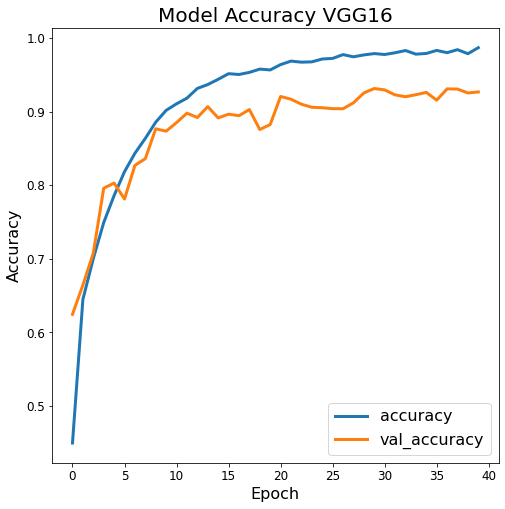

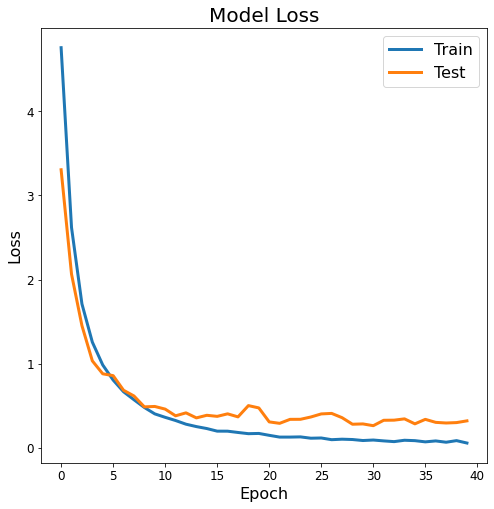

In [ ]:
figure_accuracy(f,model_name,history)
figure_loss(f,model_name,history)

In [ ]:
print(l_names)
print(len(y_test2))
print(len(y_prediction))
print(f)

['nevus melanocítico', 'Melanoma', 'Queratosis benigna ', 'carcinoma basocelular', 'Queratosis actínica / enfermedad de Bowen', 'lesión vascular', 'dermatofibroma']
7970
7970
./drive/MyDrive/Colab_Notebooks/CNN/VGG16/


0.9552867464506531

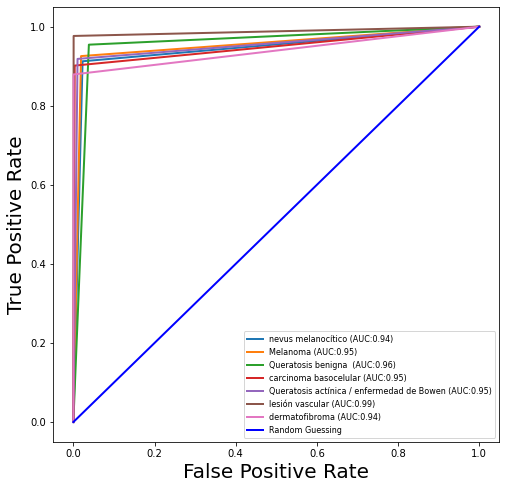

In [ ]:
multiclass_roc_auc_score(l_names,y_test2,y_prediction,f)